<a href="https://colab.research.google.com/github/Laballee/Deep-learning-fundamentals/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install torchviz

In [10]:
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
from torch import nn, optim
from torchviz import make_dot
import torch.utils.data as Data
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score



In [11]:
DEVICE = 'cuda'if torch.cuda.is_available() else'cpu'
DEVICE

'cuda'

In [12]:
# Data Transformation
transformers = Compose(transforms=[ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Data Loading
# # CIFAR-10 consists of ten classes with a total of 50,000 training images and 10,000 test images.
# The data format is 3-channel 32x32 color images.
dataset_train = CIFAR10(root='./data', train=True, download=True, transform=transformers)
dataset_test = CIFAR10(root='./data', train=False, download=True, transform=transformers)
# Split the training dataset into training and validation sets
BATCH_SIZE = 64
num_train = int(0.9*len(dataset_train))
num_val = int(0.1*len(dataset_train))
dataset_train,dataset_val=random_split(dataset_train,[num_train,num_val])
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
img,label = dataset_train[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 7
Label (textual): horse


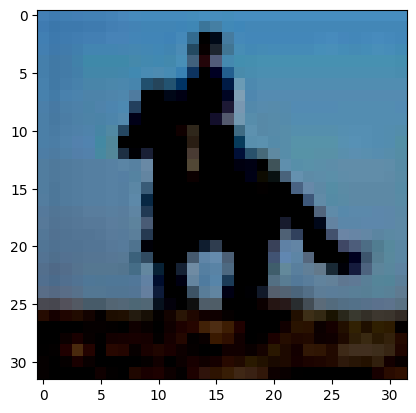

In [14]:
img, label = dataset_train[3]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

images.shape: torch.Size([64, 3, 32, 32])


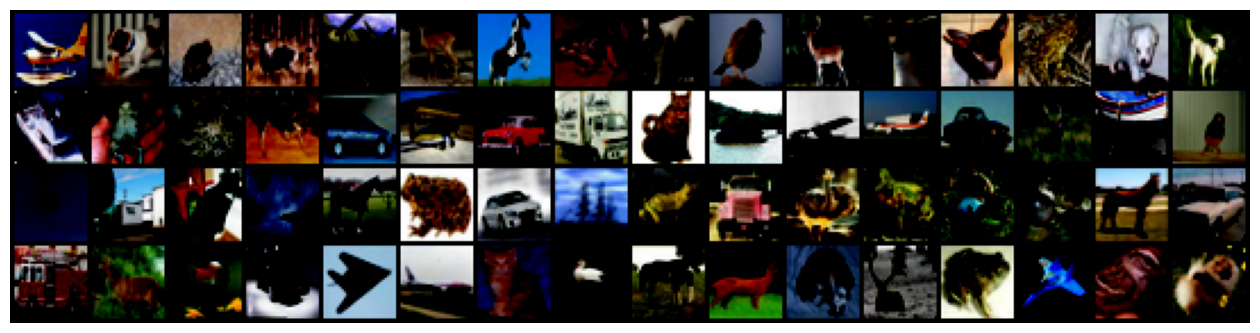

In [15]:
for images, _ in dataloader_train:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

**AlexNet**

In [16]:
# Define the AlexNet network
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()
   # Define each convolutional layer
    self.layer1 = nn.Sequential(
# Convolutional layer
# Input image is 3*32*32
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
# Stride defaults to 1
# Output size=(input_size - kernel_size + 2*padding) / stride + 1 = (32 - 3 + 2*1) / 1 + 1 = 32
# Output: 32*32*32 = 32768
# Pooling layer
        nn.MaxPool2d(kernel_size=2, stride=2),
# Padding defaults to 0
# Output size=(input_size - kernel_size + 2*padding) / stride + 1 = (32 - 2 + 2*0) / 2 + 1 = 16
# Output: 32*16*16 = 8192
# Activation function - ReLU
        nn.ReLU(inplace=True),
)
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
# Output size=(input_size - kernel_size + 2*padding) / stride + 1 = (16 - 3 + 2*1) / 1 + 1 = 16
# Output: 64*16*16 = 16384
        nn.MaxPool2d(kernel_size=2, stride=2),
# Output size=(input_size - kernel_size + 2*padding) / stride + 1 = (16 - 2 + 2*0) / 2 + 1 = 8
# Output: 64*8*8 = 4096
        nn.ReLU(inplace=True),
)
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
# Output size=(input_size - kernel_size + 2*padding) / stride + 1 = (8 - 3 + 2*1) / 1 + 1 = 8
# Output: 128*8*8 = 8192
)
    self.layer4 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
# output_size=(input_size - kernel_size + 2*padding) / stride + 1= （8- 3+ 2*1）/1+ 1= 8
# Output：256* 8* 8= 16384

)
    self.layer5 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
# Output size=(input_size - kernel_size + 2*padding) / stride + 1 = (8 - 3 + 2*1) / 1 + 1 = 8
# Output: 256*8*8 = 16384
        nn.MaxPool2d(kernel_size=3, stride=2),
# When calculating output size with non-integer values, it rounds down
# Output size=(input_size - kernel_size + 2*padding) / stride + 1 = (8 - 3 + 2*0) / 2 + 1 = 3
# Output: 256*3*3 = 2034
        nn.ReLU(inplace=True),

)

# Define fully connected layers
    self.fc1 = nn.Linear(256* 3* 3, 1024) # 2304- > 1024
    self.fc2 = nn.Linear(1024, 512)  # 1024- > 512
    self.fc3 = nn.Linear(512, 10)   # 512- > 10

# Corresponding to the output for ten categories

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = x.view(-1, 256* 3* 3)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    return x

In [17]:
Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []
model = AlexNet().to(DEVICE)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
# Use Stochastic Gradient Descent optimization with a learning rate of 0.001 and momentum of 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
print(model)

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): 

In [19]:
# Define model training process
Loss= []   # Calculate the loss rate
Accuracy= []  # Calculate accuracy
def train_runner(model, device, trainloader, optimizer, epoch):
# Train the model, enable BatchNormalization and Dropout by setting BatchNormalization and Dropout to True
  model.train()
  total = 0
  correct =0.0
# Enumerate through the loaded dataset, along with data and data indices
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
  # Initialize gradients
    optimizer.zero_grad()
  # Save the training results
    outputs = model(inputs).to(device)
  # Calculate the loss
    loss = F.cross_entropy(outputs, labels)
  # Get predictions with the highest probability
  # dim=1 indicates returning the column index with the highest value for each row
    predict = outputs.argmax(dim=1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()
  # Backpropagation
    loss.backward()
  # Update parameters
    optimizer.step()
    if i % 1000== 0:
  # loss.item() represents the current loss
      Loss.append(loss.item())
      Accuracy.append(correct/total)
  return loss.item(), 100*correct/total

# Define model test process
def test_runner(model, device, testloader):
  model.eval()
# Initialize accuracy calculation
  correct = 0.0
  test_loss = 0.0
  total = 0
# torch.no_grad() ensures that no gradients are calculated, and no backpropagation is performed
  with torch.no_grad():
    for data, label in testloader:
      data, label = data.to(device), label.to(device)
      output = model(data).to(device)
      test_loss += F.cross_entropy(output, label).item()
      predict = output.argmax(dim=1)
# Calculate the number of correct predictions
      total += label.size(0)
      correct += (predict == label).sum().item()
# Calculate the loss value
    print("Test Loss: {:.6f}, Test Accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))
  return test_loss/total, 100*correct/total

In [20]:
BATCH_SIZE = 64
EPOCHS = 40
Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []
for epoch in range(1, EPOCHS+1):
  t_loss, t_acc = train_runner(model, DEVICE, dataloader_train, optimizer, epoch)
  print("Epoch{} \t Train Loss: {:.6f}, Train Accuracy: {:.6f}%".format(epoch, t_loss, t_acc))
  Train_Loss.append(t_loss)
  Train_Accuracy.append(t_acc)
  v_loss,v_acc = train_runner(model, DEVICE, dataloader_val, optimizer, epoch)
  print("Validation Loss: {:.6f}, Validation Accuracy: {:.6f}%".format(v_loss, v_acc))
  Valid_Loss.append(v_loss)
  Valid_Accuracy.append(v_acc)
  test_runner(model, DEVICE, dataloader_test)
  print('\n')

Epoch1 	 Train Loss: 2.283007, Train Accuracy: 10.724444%
Validation Loss: 2.237621, Validation Accuracy: 20.260000%
Test Loss: 0.035681, Test Accuracy: 21.780000%


Epoch2 	 Train Loss: 2.476302, Train Accuracy: 23.560000%
Validation Loss: 1.867634, Validation Accuracy: 27.820000%
Test Loss: 0.030016, Test Accuracy: 30.500000%


Epoch3 	 Train Loss: 1.258947, Train Accuracy: 33.620000%
Validation Loss: 2.000861, Validation Accuracy: 36.180000%
Test Loss: 0.026040, Test Accuracy: 39.010000%


Epoch4 	 Train Loss: 1.775593, Train Accuracy: 40.680000%
Validation Loss: 1.089167, Validation Accuracy: 42.500000%
Test Loss: 0.023727, Test Accuracy: 44.130000%


Epoch5 	 Train Loss: 0.951246, Train Accuracy: 45.580000%
Validation Loss: 1.690129, Validation Accuracy: 46.800000%
Test Loss: 0.022174, Test Accuracy: 48.140000%


Epoch6 	 Train Loss: 1.478165, Train Accuracy: 49.526667%
Validation Loss: 1.599734, Validation Accuracy: 51.240000%
Test Loss: 0.020852, Test Accuracy: 52.050000%


Epoc

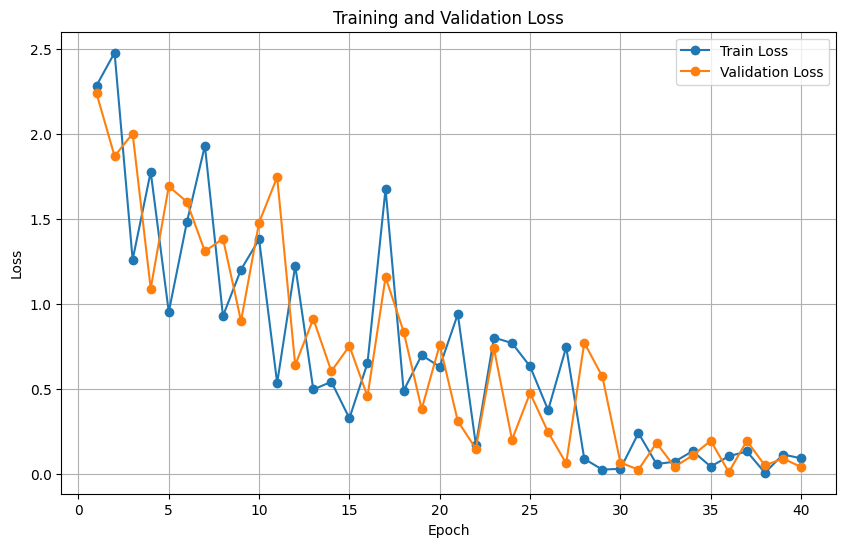

In [21]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, EPOCHS + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Loss, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, Valid_Loss, label='Validation Loss', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


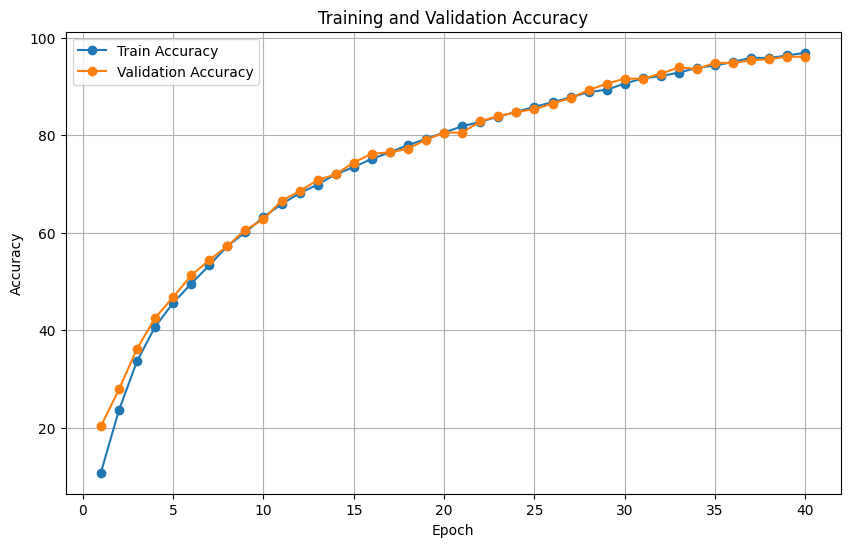

In [22]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, EPOCHS + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Accuracy, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, Valid_Accuracy, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

**Vgg_16Net**

In [23]:
# Define VGG_16Net network
class VGG_16Net(nn.Module):
  def __init__(self):
    super(VGG_16Net, self).__init__()
# Define convolutional layers
    self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU()
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.relu2 = nn.ReLU()
    self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
    self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
    self.conv7 = nn.Conv2d(128, 128, 1, padding=1)
    self.pool3 = nn.MaxPool2d(2, 2, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.relu3 = nn.ReLU()
    self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
    self.pool4 = nn.MaxPool2d(2, 2, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.relu4 = nn.ReLU()
    self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
    self.pool5 = nn.MaxPool2d(2, 2, padding=1)
    self.bn5 = nn.BatchNorm2d(512)
    self.relu5 = nn.ReLU()
    self.fc14 = nn.Linear(512* 4* 4, 1024)
    self.drop1 = nn.Dropout2d()
    self.fc15 = nn.Linear(1024, 1024)
    self.drop2 = nn.Dropout2d()
    self.fc16 = nn.Linear(1024, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.pool1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.pool2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.pool3(x)
    x = self.bn3(x)
    x = self.relu3(x)
    x = self.conv8(x)
    x = self.conv9(x)
    x = self.conv10(x)
    x = self.pool4(x)
    x = self.bn4(x)
    x = self.relu4(x)
    x = self.conv11(x)
    x = self.conv12(x)
    x = self.conv13(x)
    x = self.pool5(x)
    x = self.bn5(x)
    x = self.relu5(x)
    x = x.view(-1, 512* 4* 4)
    x = F.relu(self.fc14(x))
    x = self.drop1(x)
    x = F.relu(self.fc15(x))
    x = self.drop2(x)
    x = self.fc16(x)
    return x

In [24]:
model_2 = VGG_16Net().to(DEVICE)
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
print(model_2)

VGG_16Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1

In [25]:
BATCH_SIZE = 64
EPOCHS = 40
Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []
for epoch in range(1, EPOCHS+1):
  t_loss, t_acc = train_runner(model_2, DEVICE, dataloader_train, optimizer_2, epoch)
  print("Epoch{} \t Train Loss: {:.6f}, Train Accuracy: {:.6f}%".format(epoch, t_loss, t_acc))
  Train_Loss.append(t_loss)
  Train_Accuracy.append(t_acc)
  v_loss,v_acc = train_runner(model_2, DEVICE, dataloader_val, optimizer_2, epoch)
  print("Validation Loss: {:.6f}, Validation Accuracy: {:.6f}%".format(v_loss, v_acc))
  Valid_Loss.append(v_loss)
  Valid_Accuracy.append(v_acc)
  test_runner(model_2, DEVICE, dataloader_test)
  print('\n')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch1 	 Train Loss: 1.307661, Train Accuracy: 40.180000%
Validation Loss: 0.992841, Validation Accuracy: 54.920000%
Test Loss: 0.019315, Test Accuracy: 56.400000%


Epoch2 	 Train Loss: 0.839675, Train Accuracy: 63.615556%
Validation Loss: 1.209836, Validation Accuracy: 68.400000%
Test Loss: 0.014024, Test Accuracy: 68.600000%


Epoch3 	 Train Loss: 0.780710, Train Accuracy: 73.511111%
Validation Loss: 0.279933, Validation Accuracy: 75.380000%
Test Loss: 0.013588, Test Accuracy: 71.390000%


Epoch4 	 Train Loss: 0.650553, Train Accuracy: 78.344444%
Validation Loss: 0.338284, Validation Accuracy: 79.020000%
Test Loss: 0.011820, Test Accuracy: 75.600000%


Epoch5 	 Train Loss: 0.604809, Train Accuracy: 82.493333%
Validation Loss: 0.522250, Validation Accuracy: 82.820000%
Test Loss: 0.010606, Test Accuracy: 78.370000%


Epoch6 	 Train Loss: 0.725228, Train Accuracy: 85.291111%
Validation Loss: 1.215919, Validation Accuracy: 85.520000%
Test Loss: 0.012555, Test Accuracy: 77.270000%


Epoc

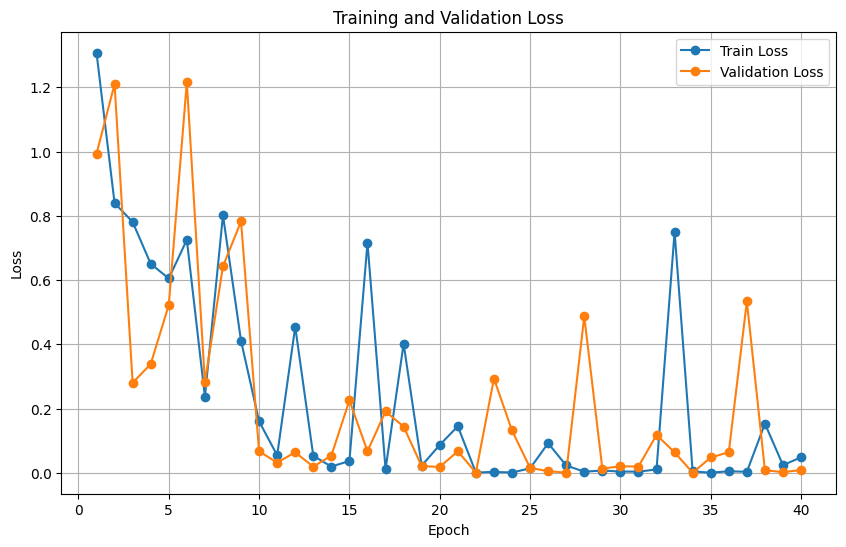

In [26]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, EPOCHS + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Loss, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, Valid_Loss, label='Validation Loss', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


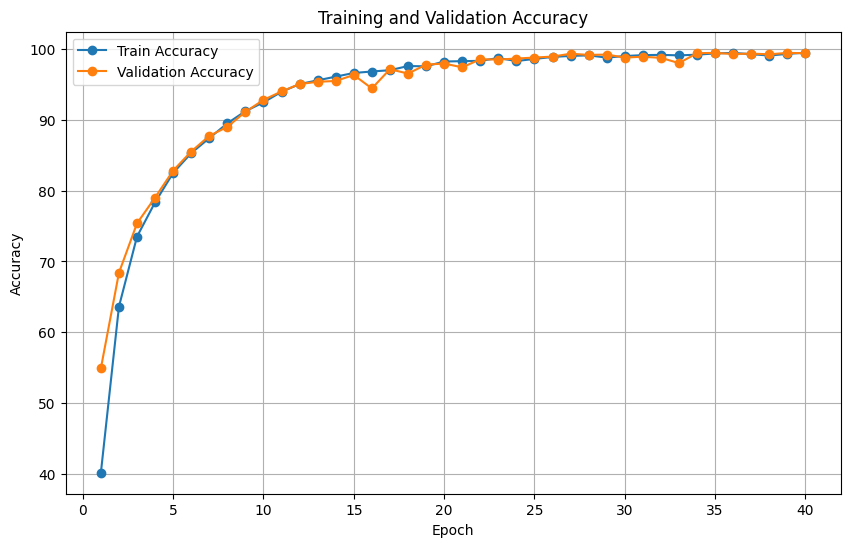

In [27]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, EPOCHS + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Accuracy, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, Valid_Accuracy, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

**ResNet**

In [44]:
import math
# Define Resnet network
# Define a 3x3 convolution function
def conv3x3(in_channels, out_channels, kernel_size = 3,stride=1, padding=1):
  return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                     stride=stride, padding=padding, bias=False)

# ResNet-50 Residual Block
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(ResidualBlock, self).__init__()
    self.mid_channels = out_channels//4
    self.conv1 = conv3x3(in_channels, self.mid_channels, kernel_size=1, stride=stride, padding=0)
    self.bn1 = nn.BatchNorm2d(self.mid_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(self.mid_channels, self.mid_channels)
    self.bn2 = nn.BatchNorm2d(self.mid_channels)
    self.conv3 = conv3x3(self.mid_channels, out_channels,kernel_size=1,padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels)
    self.downsample_0 = conv3x3(in_channels,out_channels,kernel_size=1,stride=1,padding=0)
    self.downsample = downsample

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.conv3(out)
    out = self.bn3(out)
    if self.downsample:
      residual = self.downsample(x)
    else:
      residual = self.downsample_0(x)
    out += residual
    out = self.bn3(out)
    out = self.relu(out)
    return out

# ResNet definition
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.conv = conv3x3(3, 64,kernel_size=7,stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(3,2,padding=1)
        self.layer1 = self.make_layer(block, 64, 256, layers[0])
        self.layer2 = self.make_layer(block, 256, 512, layers[1], 2)
        self.layer3 = self.make_layer(block, 512, 1024, layers[2], 2)
        self.layer4 = self.make_layer(block, 1024, 2048, layers[3], 2)
        self.avg_pool = nn.AvgPool2d(3,stride=1,padding=1)
        self.fc = nn.Linear(math.ceil(1)*math.ceil(1)*2048, num_classes)

  def make_layer(self, block, in_channels, out_channels, blocks, stride=1):
    downsample = None
    if(stride != 1):
      downsample = nn.Sequential(
            conv3x3(in_channels, out_channels, kernel_size=3,stride=stride),
            nn.BatchNorm2d(out_channels))
    layers = []
    layers.append(block(in_channels, out_channels, stride, downsample))
    for i in range(1, blocks):
      layers.append(block(out_channels, out_channels))
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.max_pool(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.avg_pool(out)
    out = out.view( -1,math.ceil(1)*math.ceil(1)*2048)
    return out


In [46]:
model_3 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(DEVICE)
print(model_3)
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample_0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ResidualBlock(
    

In [47]:
BATCH_SIZE = 64
EPOCHS = 20
Train_Loss = []
Train_Accuracy = []
Valid_Loss = []
Valid_Accuracy = []
for epoch in range(1, EPOCHS+1):
  t_loss, t_acc = train_runner(model_3, DEVICE, dataloader_train, optimizer_3, epoch)
  print("Epoch{} \t Train Loss: {:.6f}, Train Accuracy: {:.6f}%".format(epoch, t_loss, t_acc))
  Train_Loss.append(t_loss)
  Train_Accuracy.append(t_acc)
  v_loss,v_acc = train_runner(model_3, DEVICE, dataloader_val, optimizer_3, epoch)
  print("Validation Loss: {:.6f}, Validation Accuracy: {:.6f}%".format(v_loss, v_acc))
  Valid_Loss.append(v_loss)
  Valid_Accuracy.append(v_acc)
  test_runner(model_3, DEVICE, dataloader_test)
  print('\n')

Epoch1 	 Train Loss: 7.519379, Train Accuracy: 27.251111%
Validation Loss: 7.308592, Validation Accuracy: 38.740000%
Test Loss: 0.118618, Test Accuracy: 17.910000%


Epoch2 	 Train Loss: 6.983865, Train Accuracy: 45.104444%
Validation Loss: 6.998644, Validation Accuracy: 47.620000%
Test Loss: 0.116376, Test Accuracy: 14.410000%


Epoch3 	 Train Loss: 6.640648, Train Accuracy: 52.106667%
Validation Loss: 7.071650, Validation Accuracy: 53.300000%
Test Loss: 0.113674, Test Accuracy: 21.450000%


Epoch4 	 Train Loss: 6.524665, Train Accuracy: 56.620000%
Validation Loss: 6.033713, Validation Accuracy: 57.460000%
Test Loss: 0.109576, Test Accuracy: 30.600000%


Epoch5 	 Train Loss: 6.051105, Train Accuracy: 60.953333%
Validation Loss: 5.844367, Validation Accuracy: 62.400000%
Test Loss: 0.105801, Test Accuracy: 45.130000%


Epoch6 	 Train Loss: 5.182353, Train Accuracy: 64.144444%
Validation Loss: 5.013886, Validation Accuracy: 64.520000%
Test Loss: 0.098357, Test Accuracy: 54.520000%


Epoc

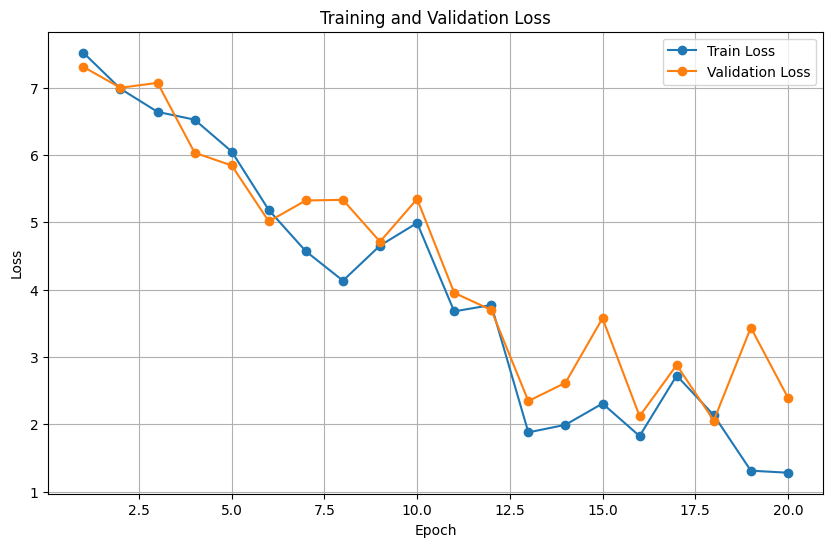

In [48]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, EPOCHS + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Loss, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, Valid_Loss, label='Validation Loss', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

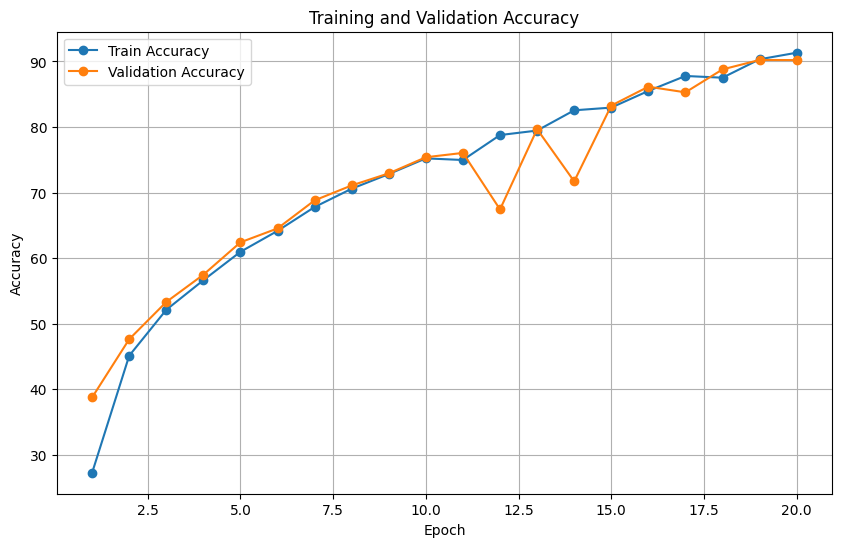

In [49]:
# Create a list of epoch numbers for the x-axis
epochs = range(1, EPOCHS + 1)

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, Train_Accuracy, label='Train Accuracy', marker='o', linestyle='-')
plt.plot(epochs, Valid_Accuracy, label='Validation Accuracy', marker='o', linestyle='-')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()